In [2]:
import jax
from jax import numpy as jnp
from matplotlib import pyplot as plt
import numpy as np
import scipy
import tensorflow as tf
import tensorflow_datasets as tfds

np.set_printoptions(suppress=True)
tf.config.experimental.set_visible_devices([], 'GPU')

In [3]:
dataset_builder = tfds.builder('mnist')
train_dataset = dataset_builder.as_dataset(
    split=tfds.Split.TRAIN,
    batch_size=dataset_builder.info.splits[tfds.Split.TRAIN].num_examples,
    as_supervised=True)
test_dataset = dataset_builder.as_dataset(
    split=tfds.Split.TEST,
    batch_size=dataset_builder.info.splits[tfds.Split.TEST].num_examples,
    as_supervised=True)

In [5]:
train_images, train_labels = next(tfds.as_numpy(train_dataset))
test_images, test_labels = next(tfds.as_numpy(test_dataset))

In [6]:
train_images = jax.device_put(train_images) / 255.
test_images = jax.device_put(test_images) / 255.
train_labels = jax.device_put(train_labels)
test_labels = jax.device_put(test_labels)

In [7]:
def pairwise_similarity(x, y, sigma2=32.):
    l2_distance = jnp.squeeze(jnp.sum(jnp.square(x - y),
                                      axis=[i for i in range(1, len(x.shape))]))
    return jnp.exp(-l2_distance/(2 * sigma2))

pairwise_similarity = jax.jit(jax.vmap(pairwise_similarity, (0, None)))
#K = []
#for i in range(0, len(train_images), 10000):
#    K.append(pairwise_similarity(train_images[i:(i + 10000)], train_images).block_until_ready())

In [8]:
# Sample
key = jax.random.PRNGKey(2020)
indices = jax.random.uniform(key, [len(train_images)]) < 0.03
train_images, train_labels = train_images[indices], train_labels[indices]

In [9]:
train_labels_one_hot = jnp.eye(10)[train_labels]

In [10]:
K = pairwise_similarity(train_images, train_images)
K_inv = jnp.linalg.inv(K)

In [11]:
f = jnp.zeros((len(K), 10))

In [12]:
@jax.jit
def loss(y, f, K_inv):
    return -(-0.5 * np.sum(jnp.einsum('bd,bd->d', f, jnp.dot(K_inv, f)))
            + jnp.sum(y * f) - jnp.sum(jnp.log(jnp.sum(jnp.exp(f), -1)))) / len(K)

loss(train_labels_one_hot, f, K_inv)

DeviceArray(2.3025854, dtype=float32)

In [13]:
loss_value_and_grad = jax.value_and_grad(loss, argnums=1)

In [14]:
step_size = 10.
current_loss = loss(train_labels_one_hot, f, K_inv)

In [15]:
for i in range(30000):
    l, grad = loss_value_and_grad(train_labels_one_hot, f, K_inv)
    if l > current_loss:
        step_size /= 2.
    current_loss = l
    f -= step_size * grad
    if step_size < 1e-3:
        break 
    if i % 1000 == 0:
        print(i, l)
l, step_size

0 2.3025854
1000 0.99362236
2000 0.89590555
3000 0.871964
4000 0.8628172
5000 0.85855216
6000 0.8564955


(DeviceArray(0.8564955, dtype=float32), 0.0006103515625)

In [16]:
jnp.sum(train_labels == jnp.argmax(f, -1)) / len(train_labels)

DeviceArray(0.948, dtype=float32)

In [17]:
k = pairwise_similarity(test_images, train_images)

In [18]:
logits = k.dot(jnp.dot(K_inv, f))
predictions = jnp.argmax(logits, -1)

In [19]:
np.sum(predictions == test_labels) / len(test_labels)

DeviceArray(0.9093, dtype=float32)

In [20]:
p = jnp.exp(f) / jnp.sum(jnp.exp(f), -1, keepdims=True)
P = jnp.vstack([jnp.diag(jnp.squeeze(x)) for x in jnp.split(p, 10, axis=1)])
P = jnp.dot(P, P.T)
W = jnp.diag(p.T.reshape((-1))) - 0.99 * P

In [21]:
W_inv = jnp.linalg.inv(W)
for i in range(10):
    W_inv = jax.ops.index_add(
        W_inv,
        jax.ops.index[(i*k.shape[1]):((i +1)*k.shape[1]),(i*k.shape[1]):((i +1)*k.shape[1])],
        K)

In [32]:
Q = jnp.zeros((10 * k.shape[1], 10))
for i in range(10):
    Q = jax.ops.index_update(Q, jax.ops.index[(i*k.shape[1]):((i +1)*k.shape[1]), i], k[0])

In [33]:
V = jnp.eye(10) - jnp.dot(Q.T, jnp.linalg.inv(W_inv)).dot(Q)

In [34]:
jnp.diag(V), predictions[0], test_labels[0]

(DeviceArray([0.7990684 , 0.84223247, 0.72025645, 0.8083943 , 0.79045683,
              0.8055764 , 0.81172144, 0.8219196 , 0.8030503 , 0.806748  ],            dtype=float32),
 DeviceArray(2, dtype=int32),
 DeviceArray(2, dtype=int32))

In [35]:
key = jax.random.PRNGKey(2020)
key, *subkeys = jax.random.split(key, 8)
#subkeys
#jax.random.PRNGKey()

In [36]:
L = jnp.linalg.cholesky(V)

In [37]:
def sample_distributions(key, L, logits):
    p = jnp.exp(L.dot(jax.random.normal(key, shape=[10])) + logits)
    return p/jnp.sum(p, -1, keepdims=True)

dist = jax.vmap(sample_distributions, (0, None, None))(jnp.vstack(subkeys), L, logits[0])

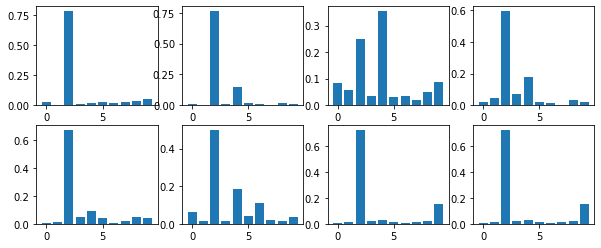

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 4))
for i, ax in enumerate(axes.reshape((-1))):
    ax.bar(list(range(10)), dist[i])
fig.savefig('2_distribution.pdf')

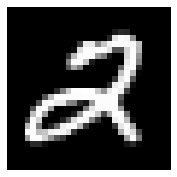

In [41]:
fig = plt.figure(figsize=(3,3))
ax = fig.gca()
ax.imshow(np.squeeze(test_images[0]), cmap='gray')
ax.axis('off')
fig.savefig('2_image.pdf')